In [70]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
torch.manual_seed(0)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [175]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    
)

In [176]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [448]:
batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64


In [623]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 18),
            nn.ReLU(),
            nn.Linear(18, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [851]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 1:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        if batch > 2000:
            return True

    correct /= size
    print(f"Training Error: \n Accuracy: {(100*correct):>0.1f}%")

    return correct

In [259]:
def forward_one(dataloader, model, loss_fn, optimizer):
    X, y1 = next(iter(dataloader))
    X =  X[0][None,:]
    y1 = y1[None,:][:,0]
    pred = model(X)
    loss = loss_fn(pred, y1)
    return loss

In [677]:
def train_one(x1,y1, model, loss_fn, optimizer):
    model.train()
    pred = model(x1)
    loss = loss_fn(pred, y1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss

In [583]:
x1, y1 = next(iter(train_dataloader))
x1 =  x1[0][None,:]
y1 = y1[None,:][:,0]
y1

tensor([5])

In [551]:
# forward_one(train_dataloader, model, loss_fn, optimizer)

<Axes: >

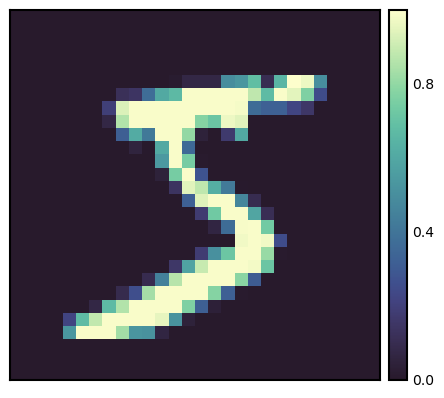

In [552]:
import seaborn_image as isns
isns.imgplot(x1.squeeze())

In [764]:
iter_=iter(train_dataloader)

In [765]:
torch.manual_seed(0)
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model.pth'))
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=10, bias=True)
  )
)


In [822]:
x1, y1 = next(iter_)
x1 =  x1[0][None,:]
y1 = y1[None,:][:,0]
y1

tensor([1])

In [823]:
model(x1)

tensor([[-0.0525, -0.0595,  0.0721, -0.1558, -0.0971, -0.0192, -0.0878,  0.2483,
          0.1709,  0.0990]], grad_fn=<AddmmBackward0>)

In [824]:
train_one(x1,y1, model, loss_fn, optimizer)

tensor(2.3817, grad_fn=<NllLossBackward0>)

In [825]:
model.state_dict()['linear_relu_stack.0.bias']

tensor([ 0.0105,  0.0017,  0.0017, -0.0253, -0.0138, -0.0099, -0.0168, -0.0133,
         0.0035,  0.0342, -0.0145, -0.0313,  0.0099,  0.0316, -0.0350,  0.0311,
         0.0259,  0.0107])

In [826]:
model.state_dict()['linear_relu_stack.2.bias']

tensor([-0.1420, -0.0604, -0.0507, -0.2054, -0.0986, -0.1237,  0.0103,  0.2327,
         0.1419,  0.1194])

In [827]:
model.state_dict()['linear_relu_stack.0.weight']

tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
        [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
        [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
        ...,
        [-0.0215,  0.0106,  0.0308,  ..., -0.0199,  0.0161, -0.0342],
        [ 0.0350, -0.0297, -0.0037,  ...,  0.0171,  0.0238, -0.0001],
        [ 0.0085,  0.0223, -0.0324,  ..., -0.0296,  0.0182, -0.0296]])

In [828]:
model.state_dict()['linear_relu_stack.2.weight'][y1]

tensor([[-0.2118, -0.0872,  0.0237,  0.0396, -0.1763,  0.2065, -0.2173,  0.1158,
         -0.1041, -0.1668,  0.1045, -0.0560, -0.0937, -0.0247, -0.0842,  0.2194,
         -0.2216, -0.0808]])

In [735]:
-model(x1)[0][5].log()

tensor(nan, grad_fn=<NegBackward0>)

In [581]:
model.state_dict()['linear_relu_stack.2.weight'][y1]

tensor([[ 0.0453, -0.1708, -0.0112, -0.1373, -0.1919,  0.1684, -0.0890,  0.1894,
         -0.1370,  0.0977, -0.0159, -0.0262,  0.1361, -0.2134,  0.1970, -0.0483,
          0.1064, -0.1399]])

In [187]:
def test(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [852]:
torch.manual_seed(0)
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model.pth'))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=10, bias=True)
  )
)


In [853]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [854]:
train(train_dataloader, model, loss_fn, optimizer)
test(test_dataloader, model, loss_fn)

loss: 2.457382  [    1/60000]
loss: 2.374321  [    2/60000]
loss: 2.398252  [    3/60000]
loss: 2.376534  [    4/60000]
loss: 2.279009  [    5/60000]
loss: 2.354060  [    6/60000]
loss: 2.389974  [    7/60000]
loss: 2.512438  [    8/60000]
loss: 2.381724  [    9/60000]
loss: 2.361736  [   10/60000]
loss: 2.445279  [   11/60000]
loss: 2.393084  [   12/60000]
loss: 2.463694  [   13/60000]
loss: 2.353185  [   14/60000]
loss: 2.354204  [   15/60000]
loss: 2.029841  [   16/60000]
loss: 2.406065  [   17/60000]
loss: 2.070472  [   18/60000]
loss: 2.292971  [   19/60000]
loss: 2.138663  [   20/60000]
loss: 2.431557  [   21/60000]
loss: 2.403752  [   22/60000]
loss: 2.184052  [   23/60000]
loss: 2.353106  [   24/60000]
loss: 2.457611  [   25/60000]
loss: 2.308816  [   26/60000]
loss: 2.388967  [   27/60000]
loss: 2.393305  [   28/60000]
loss: 2.347595  [   29/60000]
loss: 2.007248  [   30/60000]
loss: 2.381086  [   31/60000]
loss: 2.015050  [   32/60000]
loss: 2.344524  [   33/60000]
loss: 2.17

0.573

In [190]:
epochs=10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.311446  [   64/60000]
loss: 2.318978  [ 6464/60000]
loss: 2.292953  [12864/60000]
loss: 2.208490  [19264/60000]
loss: 2.216908  [25664/60000]
loss: 2.212726  [32064/60000]
loss: 2.156218  [38464/60000]
loss: 2.183332  [44864/60000]
loss: 2.104259  [51264/60000]
loss: 2.085171  [57664/60000]
Training Error: 
 Accuracy: 19.9%
Test Error: 
 Accuracy: 34.2%, Avg loss: 2.087204 

Epoch 2
-------------------------------
loss: 2.072464  [   64/60000]
loss: 2.057868  [ 6464/60000]
loss: 2.130230  [12864/60000]
loss: 1.922219  [19264/60000]
loss: 1.982769  [25664/60000]
loss: 1.972055  [32064/60000]
loss: 1.903299  [38464/60000]
loss: 1.992909  [44864/60000]
loss: 1.859344  [51264/60000]
loss: 1.851977  [57664/60000]
Training Error: 
 Accuracy: 47.5%
Test Error: 
 Accuracy: 54.7%, Avg loss: 1.838495 

Epoch 3
-------------------------------
loss: 1.818471  [   64/60000]
loss: 1.774000  [ 6464/60000]
loss: 1.917660  [12864/60000]
loss: 1.640146  [1

KeyboardInterrupt: 

## Overfitting testing

In [173]:
'''
I want to make a graph of the training error and the test error after X number of epochs!. But wait, I can just record the test error after each epoch! that will save some time...
'''
torch.manual_seed(0)
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

train_acc = np.array([])
test_acc = np.array([])
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc = np.hstack((train_acc, train(train_dataloader, model, loss_fn, optimizer)))
    test_acc = np.hstack((test_acc, test(test_dataloader, model, loss_fn)))
print("Done!")

Epoch 1
-------------------------------
loss: 2.311446  [   64/60000]
loss: 2.318978  [ 6464/60000]
loss: 2.292953  [12864/60000]
loss: 2.208490  [19264/60000]
loss: 2.216908  [25664/60000]
loss: 2.212726  [32064/60000]
loss: 2.156218  [38464/60000]
loss: 2.183332  [44864/60000]
loss: 2.104259  [51264/60000]
loss: 2.085171  [57664/60000]
Training Error: 
 Accuracy: 19.9%
Test Error: 
 Accuracy: 34.2%, Avg loss: 2.087204 

Epoch 2
-------------------------------
loss: 2.072464  [   64/60000]
loss: 2.057868  [ 6464/60000]
loss: 2.130230  [12864/60000]
loss: 1.922219  [19264/60000]
loss: 1.982769  [25664/60000]
loss: 1.972055  [32064/60000]
loss: 1.903299  [38464/60000]
loss: 1.992909  [44864/60000]
loss: 1.859344  [51264/60000]
loss: 1.851977  [57664/60000]
Training Error: 
 Accuracy: 47.5%
Test Error: 
 Accuracy: 54.7%, Avg loss: 1.838495 

Epoch 3
-------------------------------
loss: 1.818471  [   64/60000]
loss: 1.774000  [ 6464/60000]
loss: 1.917660  [12864/60000]
loss: 1.640146  [1

TypeError: 'NoneType' object is not iterable

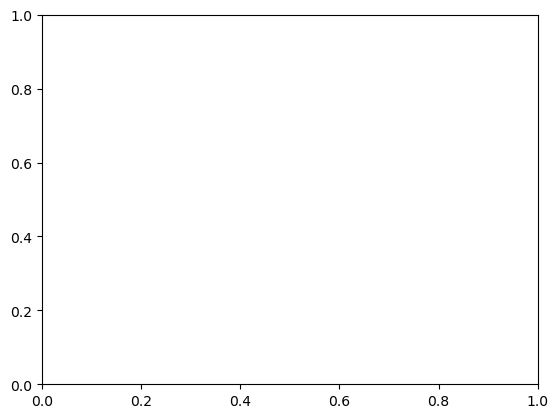

In [174]:
import seaborn as sns
sns.lineplot((1-train_acc, 1-test_acc))
